In [130]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen, HTTPError, URLError
from urllib.parse import urlparse
import re
from concurrent.futures import ThreadPoolExecutor, TimeoutError
from bs4 import BeautifulSoup




%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
twt_data = pd.read_csv('../../../DataSets/twt_train.csv')
twt_data_with_links_saved = pd.read_csv('../../../DataSets/twt_with_links.csv')

In [71]:
twt_data

,id,keyword,location,text,target,for_graphics
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,1


In [72]:
twt_data.describe()

,id,target,for_graphics
count,"7,613.00","7,613.00","7,613.00"
mean,"5,441.93",0.43,1.00
std,"3,137.12",0.50,0.00
min,1.00,0.00,1.00
25%,"2,734.00",0.00,1.00
50%,"5,408.00",0.00,1.00
75%,"8,146.00",1.00,1.00
max,"10,873.00",1.00,1.00


In [73]:
twt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7613 non-null   int64 
 1   keyword       7552 non-null   object
 2   location      5080 non-null   object
 3   text          7613 non-null   object
 4   target        7613 non-null   int64 
 5   for_graphics  7613 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 267.7+ KB


In [74]:
def obtain_link(twt):
    url = re.search("(?P<url>https?://[^\s]+)", twt)
    return url.group("url") if url else np.NaN  

In [75]:
twt_data['link'] = twt_data['text'].map(obtain_link)
twt_data

,id,keyword,location,text,target,for_graphics,link
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,NaN
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,NaN
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1,NaN
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,NaN
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,NaN
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,1,http://t.co/STfMbbZFB5
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,1,NaN
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,1,http://t.co/zDtoyd8EbJ
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,1,NaN


In [ ]:
twt_data.info()

In [ ]:
def isShorted(link):
    if link != link: return np.NaN 
    return 't.co' in str(link)

In [ ]:
twt_data['link_shorted'] = twt_data['link'].map(isShorted)


In [ ]:
twt_data

In [ ]:
twt_data_with_links = twt_data.dropna(subset=['link'])
twt_data_with_links

In [ ]:
twt_data_with_links = twt_data_with_links[twt_data_with_links['link_shorted']]
twt_data_with_links

In [ ]:
twt_data_with_links.info()

In [ ]:
twt_data_with_links['real_link'] = 'np.NaN'
twt_data_with_links['error'] = 'np.NaN'
twt_data_with_links['page'] = 'np.NaN'
twt_data_with_links = twt_data_with_links.reset_index()
twt_data_with_links.info()

In [ ]:
def obtain_real_link(index, url):
    try:
        with urlopen(url, timeout = 20) as response:
            actual_url = response.geturl()
            error = np.NaN
            page = response.read()
    except HTTPError as e:
        actual_url = e.url
        error = e
        page = np.NaN
    except URLError as e:
        actual_url = url
        error = e
        page = np.NaN
    except:
        actual_url = url
        error = 'OTHER_ERROR'
        page = np.NaN
    return (index, actual_url, error, page)

In [ ]:
def doWork(row):
    return obtain_real_link(row[0], row[1]['link'])

In [69]:
twt_data_with_links = twt_data_with_links_saved

In [233]:
twt_data_with_links.head()

,id,keyword,location,text,target,link,link_shorted,real_link,error,page,error_code
0,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,http://t.co/lHYXEOHY6C,True,https://twitter.com/dannypurewal/status/629284...,HTTP Error 404: Not Found,NaN,404.00
1,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,http://t.co/YAo1e0xngw,True,https://twitter.com/Valis_Ablaze/status/629274...,NaN,"b'<!DOCTYPE html>\n<html lang=""es"" data-scribe...",nan
2,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,http://t.co/2nndBGwyEi,True,https://africanbaze.com/breaking-newsnigeria-f...,HTTP Error 404: Not Found,NaN,404.00
3,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,http://t.co/qqsmshaJ3N,True,https://twitter.com/AnyOtherAnnaK/status/62919...,NaN,"b'<!DOCTYPE html>\n<html lang=""es"" data-scribe...",nan
4,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1,http://t.co/3ImaomknnA,True,http://yabaleftonline.com/2015/08/inec-office-...,HTTP Error 403: Forbidden,NaN,403.00


In [234]:
twt_data_with_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3968 entries, 0 to 3967
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            3968 non-null   int64  
 1   keyword       3948 non-null   object 
 2   location      2714 non-null   object 
 3   text          3968 non-null   object 
 4   target        3968 non-null   int64  
 5   link          3968 non-null   object 
 6   link_shorted  3968 non-null   bool   
 7   real_link     3968 non-null   object 
 8   error         1758 non-null   object 
 9   page          2214 non-null   object 
 10  error_code    1386 non-null   float64
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 205.4+ KB


In [235]:
twt_data_with_links['site'] = twt_data_with_links['real_link'].map(lambda x: urlparse(x).netloc)
twt_data_with_links

,id,keyword,location,text,target,link,link_shorted,real_link,error,page,error_code,site
0,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,http://t.co/lHYXEOHY6C,True,https://twitter.com/dannypurewal/status/629284...,HTTP Error 404: Not Found,NaN,404.00,twitter.com
1,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,http://t.co/YAo1e0xngw,True,https://twitter.com/Valis_Ablaze/status/629274...,NaN,"b'<!DOCTYPE html>\n<html lang=""es"" data-scribe...",nan,twitter.com
2,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,http://t.co/2nndBGwyEi,True,https://africanbaze.com/breaking-newsnigeria-f...,HTTP Error 404: Not Found,NaN,404.00,africanbaze.com
3,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,http://t.co/qqsmshaJ3N,True,https://twitter.com/AnyOtherAnnaK/status/62919...,NaN,"b'<!DOCTYPE html>\n<html lang=""es"" data-scribe...",nan,twitter.com
4,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1,http://t.co/3ImaomknnA,True,http://yabaleftonline.com/2015/08/inec-office-...,HTTP Error 403: Forbidden,NaN,403.00,yabaleftonline.com
...,...,...,...,...,...,...,...,...,...,...,...,...
3963,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,http://t.co/nF4IculOje,True,https://www.reuters.com/article/us-saudi-secur...,NaN,b'<!--[if !IE]> This has been served from cach...,nan,www.reuters.com
3964,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1,http://t.co/3SICroAaNz,True,http://t.co/3SICroAaNz,<urlopen error [Errno -2] Name or service not ...,NaN,nan,t.co
3965,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,http://t.co/STfMbbZFB5,True,https://gizmodo.com/two-giant-cranes-holding-a...,NaN,"b'<!DOCTYPE html><html lang=""en-us"" data-react...",nan,gizmodo.com
3966,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,http://t.co/zDtoyd8EbJ,True,https://earthquake.usgs.gov/earthquakes/eventp...,NaN,"b'<!doctype html>\n<html lang=""en"">\n\n<head>\...",nan,earthquake.usgs.gov


In [ ]:
twt_data_with_links['site'].value_counts()

In [ ]:
twt_data_with_links.loc[twt_data_with_links['error'] != twt_data_with_links['error'], 'site'].value_counts()

In [ ]:
twt_data_with_links['target'].value_counts()

In [ ]:
twt_data_with_links.loc[twt_data_with_links['error'] != twt_data_with_links['error'], 'target'].value_counts()

In [ ]:
twt_data_with_links_without_error = twt_data_with_links.loc[twt_data_with_links['error'] != twt_data_with_links['error']]
twt_data_with_links_without_error

In [ ]:
twt_data_with_links_without_error.loc[twt_data_with_links_without_error['target'] == 1, 'site'].value_counts()

In [ ]:
twt_data_with_links_without_error.loc[twt_data_with_links_without_error['target'] == 0, 'site'].value_counts()

In [ ]:
twt_data_with_links_without_error.loc[7601, 'real_link']

In [ ]:
soup = BeautifulSoup(twt_data_with_links_without_error.loc[7601, 'page'], "lxml")

In [ ]:
soup.h1.string


In [ ]:
def get_the_header(page):
    soup = BeautifulSoup(page, "lxml")
    return soup.h1.string if soup.h1 else ''

In [ ]:
twt_data_with_links_without_error['header'] = twt_data_with_links_without_error['page'].map(get_the_header)
twt_data_with_links_without_error

In [ ]:
twt_data_with_links_without_error['header'] = twt_data_with_links_without_error['header'].str.replace('\n', '')
twt_data_with_links_without_error['header'] = twt_data_with_links_without_error['header'].str.replace(',', '')
twt_data_with_links_without_error['header'] = twt_data_with_links_without_error['header'].str.replace('.', '')
twt_data_with_links_without_error['header'] = twt_data_with_links_without_error['header'].str.replace(':', '')
twt_data_with_links_without_error

In [ ]:
twt_data_with_links_without_error['header_splited'] = twt_data_with_links_without_error['header'].str.split(' ')

In [ ]:
def count_words(word, count):
    if(word == None or word == ''):
        return
    if (word in count):
        count[word] = count[word] + 1
        return
    count[word] = 1
        

In [ ]:
total_word_count = {}
twt_data_with_links_without_error['header_splited'].map(
    lambda x: [count_words(word, total_word_count) for word in x] if (x != None) else None
)
total_word_count

In [ ]:
disaster_word_count = {}
twt_data_with_links_without_error.loc[twt_data_with_links_without_error['target'] == 1,'header_splited'].map(
    lambda x: [count_words(word, disaster_word_count) for word in x] if (x != None) else None
)
disaster_word_count

In [ ]:
normal_word_count = {}
twt_data_with_links_without_error.loc[twt_data_with_links_without_error['target'] == 0,'header_splited'].map(
    lambda x: [count_words(word, normal_word_count) for word in x] if (x != None) else None
)
normal_word_count

In [ ]:
{k: v for k, v in sorted(normal_word_count.items(), key=lambda item: item[1], reverse = True)}


In [ ]:
{k: v for k, v in sorted(disaster_word_count.items(), key=lambda item: item[1], reverse = True)}


In [ ]:
{k: v for k, v in sorted(total_word_count.items(), key=lambda item: item[1], reverse = True)}


In [7]:
twt_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Text(0, 0.5, 'Cantidad')

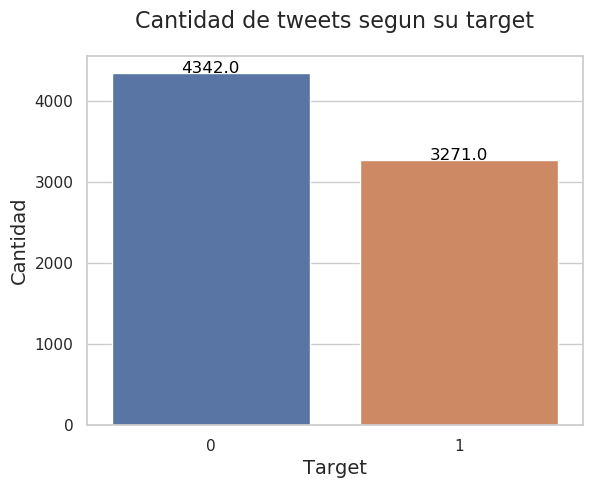

In [217]:
twt_data['for_graphics'] = 1
grouped_twt = twt_data.groupby('target').sum().reset_index()
g = sns.barplot(x='target', y='for_graphics', data=grouped_twt)
for index, row in grouped_twt.iterrows():
    g.text(row.target, row.for_graphics, row.for_graphics, color='black', ha="center")
g.set_title("Cantidad de tweets segun su target", fontsize=16, pad=20)
g.set_xlabel("Target", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)

In [81]:
def is_not_nan(value):
    return value == value

In [83]:
twt_data['with_link'] = twt_data['link'].map(is_not_nan)
twt_data

,id,keyword,location,text,target,for_graphics,link,with_link
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,NaN,False
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,NaN,False
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1,NaN,False
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,NaN,False
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,NaN,False
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,1,http://t.co/STfMbbZFB5,True
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,1,NaN,False
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,1,http://t.co/zDtoyd8EbJ,True
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,1,NaN,False


Text(0, 0.5, 'Cantidad')

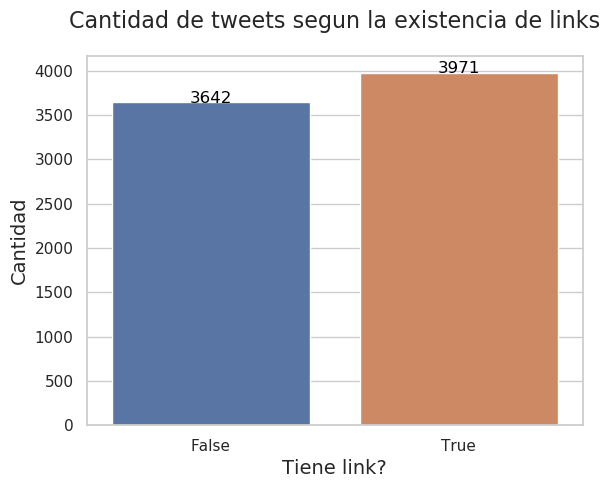

In [216]:
grouped_twt = twt_data.groupby('with_link').sum().reset_index()
g = sns.barplot(x='with_link', y='for_graphics', data=grouped_twt)
for index, row in grouped_twt.iterrows():
    g.text(row.name, row.for_graphics, row.for_graphics, color='black', ha="center")
g.set_title("Cantidad de tweets segun la existencia de links", fontsize=16, pad=20)
g.set_xlabel("Tiene link?", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)

Text(0, 0.5, 'Cantidad')

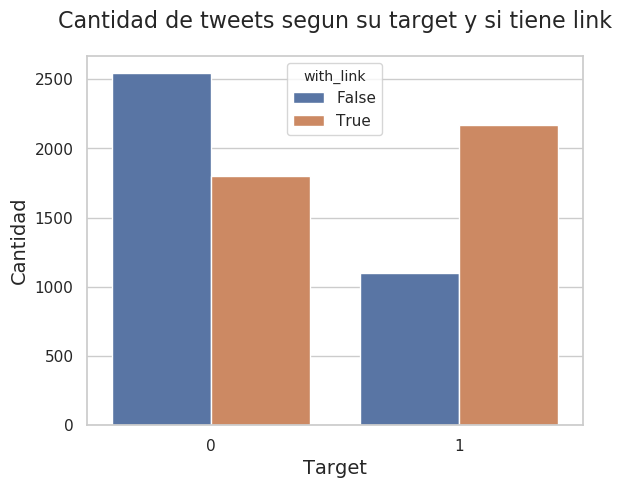

In [150]:
grouped_twt = twt_data.groupby(['target', 'with_link']).sum().reset_index()
g = sns.barplot(x='target', y='for_graphics', hue='with_link', data=grouped_twt)
g.set_title("Cantidad de tweets segun su target y si tiene link", fontsize=16, pad=20)
g.set_xlabel("Target", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)

In [171]:
grouped_by_target_twt = twt_data.groupby(['target']).sum().reset_index()
grouped_by_links_twt = twt_data.groupby(['target', 'with_link']).sum().reset_index()


In [172]:
grouped_by_target_twt

,target,id,for_graphics,with_link
0,0,22910330,4342,"1,799.00"
1,1,18519120,3271,"2,172.00"


In [173]:
grouped_by_links_twt

,target,with_link,id,for_graphics
0,0,False,13588868,2543
1,0,True,9321462,1799
2,1,False,5894662,1099
3,1,True,12624458,2172


In [184]:
grouped_by_links_twt.loc[grouped_by_links_twt['with_link'] == False, 'for_graphics'] = grouped_by_target_twt.loc[:, 'for_graphics']
grouped_by_links_twt

,target,with_link,id,for_graphics
0,0,False,13588868,"4,342.00"
1,0,True,9321462,"1,799.00"
2,1,False,5894662,nan
3,1,True,12624458,"2,172.00"


In [189]:
grouped_by_links_twt.loc[grouped_by_links_twt['with_link'] == False, 'for_graphics'] = grouped_by_target_twt['for_graphics'].tolist()
grouped_by_links_twt.loc[grouped_by_links_twt['with_link'] == False, 'with_link'] = 'Total'
grouped_by_links_twt

,target,with_link,id,for_graphics
0,0,Total,13588868,"4,342.00"
1,0,True,9321462,"1,799.00"
2,1,Total,5894662,"3,271.00"
3,1,True,12624458,"2,172.00"


Text(0, 0.5, 'Cantidad')

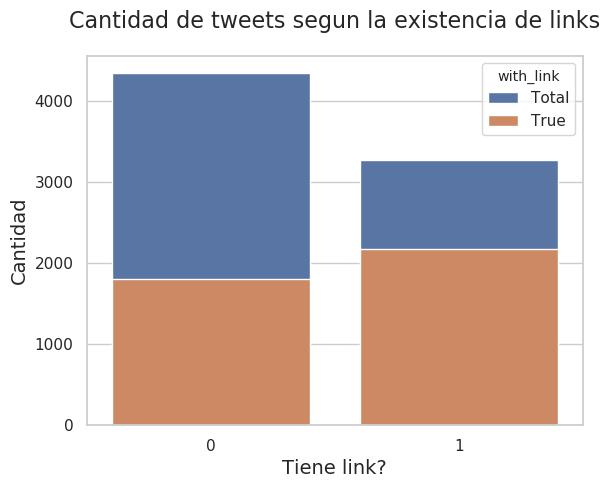

In [225]:
g = sns.barplot(x = 'target', y = 'for_graphics', data=grouped_by_links_twt, hue='with_link', dodge=False)
g.set_title("Cantidad de tweets segun la existencia de links", fontsize=16, pad=20)
g.set_xlabel("Tiene link?", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)

Text(0, 0.5, 'Cantidad')

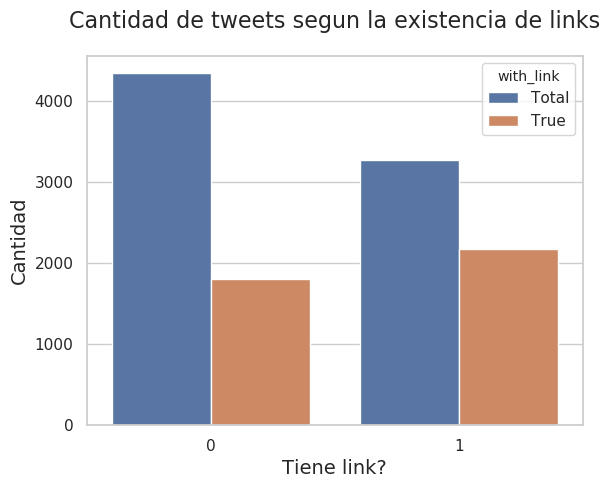

In [226]:
g = sns.barplot(x = 'target', y = 'for_graphics', data=grouped_by_links_twt, hue='with_link')
g.set_title("Cantidad de tweets segun la existencia de links", fontsize=16, pad=20)
g.set_xlabel("Tiene link?", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)

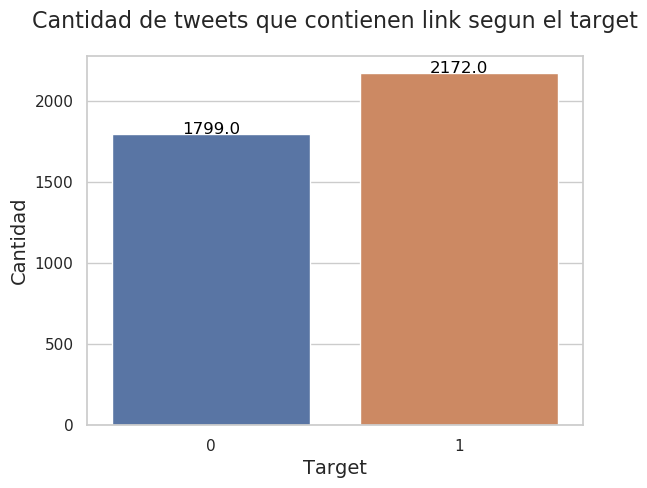

In [229]:
twt_with_link = grouped_by_links_twt.loc[grouped_by_links_twt['with_link'] == True]
g = sns.barplot(x = 'target', y = 'for_graphics', data=twt_with_link)
g.set_title("Cantidad de tweets que contienen link segun el target", fontsize=16, pad=20)
g.set_xlabel("Target", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)
for index, row in twt_with_link.iterrows():
    g.text(row.target, row.for_graphics, row.for_graphics, color='black', ha="center")

A continuacion trabajaremos exclusivamente con los twits que poseen links

In [236]:
twt_data_with_links = twt_data_with_links.drop(columns=['Unnamed: 0'])
twt_data_with_links['for_graphics'] = 1
twt_data_with_links

KeyError: "['Unnamed: 0'] not found in axis"

In [240]:
grouped_by_sites = twt_data_with_links.groupby('site').sum()
grouped_by_sites

,id,target,link_shorted,error_code,for_graphics
site,,,,,
,21300,1,4.00,0.00,4
1.usa.gov,125663,13,15.00,"6,060.00",15
1080plus.com,1770,1,1.00,403.00,1
1stheadlines.com,10628,1,1.00,403.00,1
24x7freeadvice.wordpress.com,7843,0,1.00,410.00,1
...,...,...,...,...,...
yournewswire.com,14239,1,2.00,806.00,2
youthsnews.com.au,275378,15,40.00,0.00,40
zeenews.india.com,12563,2,2.00,806.00,2


In [244]:
sites_top_20 = grouped_by_sites.sort_values('for_graphics', ascending=False).head(20).reset_index()
sites_top_20

,site,id,target,link_shorted,error_code,for_graphics
0,twitter.com,2672117,227,514.00,"46,460.00",514
1,t.co,2129642,218,398.00,"12,120.00",398
2,www.youtube.com,878528,54,164.00,0.00,164
3,www.ebay.com,368268,8,89.00,"30,300.00",89
4,www.facebook.com,403288,37,78.00,"6,060.00",78
5,www.instagram.com,375600,19,67.00,"12,120.00",67
6,feedsportal.com,463856,58,63.00,"25,389.00",63
7,www.bbc.co.uk,458973,59,62.00,0.00,62
8,abcnews.go.com,436302,49,54.00,"21,008.00",54
9,www.latimes.com,210264,38,40.00,0.00,40


Text(0, 0.5, 'Sitios')

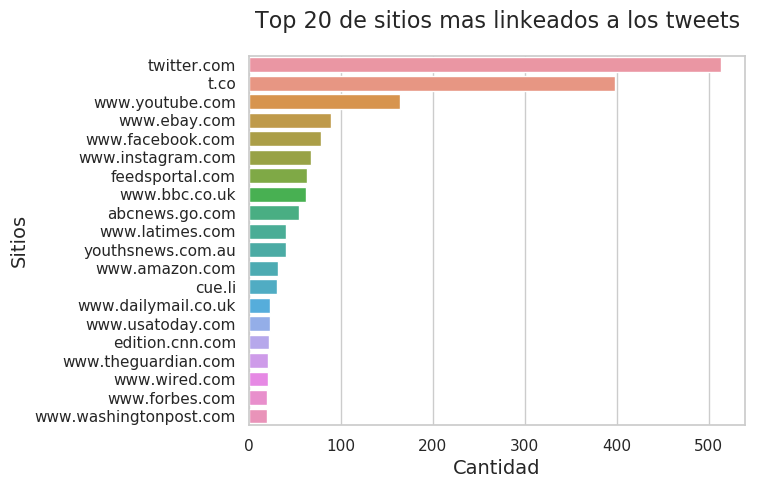

In [248]:
g = sns.barplot(x = 'for_graphics', y = 'site', data=sites_top_20)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

Dejaremos afuera el sition t.co y los que tienen como sitio twitter.com y error 

In [255]:
def filter_twitter_error(row):
    return row.site != 't.co' and (row.site != 'twitter.com' or row.error != row.error)

In [257]:
filter_list = []
for index, row in twt_data_with_links.iterrows():
    filter_list.append(filter_twitter_error(row))
twt_data_with_links.loc[filter_list]

,id,keyword,location,text,target,link,link_shorted,real_link,error,page,error_code,site,for_graphics
1,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,http://t.co/YAo1e0xngw,True,https://twitter.com/Valis_Ablaze/status/629274...,NaN,"b'<!DOCTYPE html>\n<html lang=""es"" data-scribe...",nan,twitter.com,1
2,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,http://t.co/2nndBGwyEi,True,https://africanbaze.com/breaking-newsnigeria-f...,HTTP Error 404: Not Found,NaN,404.00,africanbaze.com,1
3,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,http://t.co/qqsmshaJ3N,True,https://twitter.com/AnyOtherAnnaK/status/62919...,NaN,"b'<!DOCTYPE html>\n<html lang=""es"" data-scribe...",nan,twitter.com,1
4,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1,http://t.co/3ImaomknnA,True,http://yabaleftonline.com/2015/08/inec-office-...,HTTP Error 403: Forbidden,NaN,403.00,yabaleftonline.com,1
5,56,ablaze,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1,http://t.co/wDUEaj8Q4J,True,https://www.youtube.com/watch?v=yG08hLEWzyM,NaN,"b'<!DOCTYPE html><html lang=""en"" data-cast-api...",nan,www.youtube.com,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3962,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1,http://t.co/EYSVvzA7Qm,True,https://www.youtube.com/watch?v=yG08hLEWzyM&3,NaN,"b'<!DOCTYPE html><html lang=""en"" data-cast-api...",nan,www.youtube.com,1
3963,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,http://t.co/nF4IculOje,True,https://www.reuters.com/article/us-saudi-secur...,NaN,b'<!--[if !IE]> This has been served from cach...,nan,www.reuters.com,1
3965,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,http://t.co/STfMbbZFB5,True,https://gizmodo.com/two-giant-cranes-holding-a...,NaN,"b'<!DOCTYPE html><html lang=""en-us"" data-react...",nan,gizmodo.com,1
3966,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,http://t.co/zDtoyd8EbJ,True,https://earthquake.usgs.gov/earthquakes/eventp...,NaN,"b'<!doctype html>\n<html lang=""en"">\n\n<head>\...",nan,earthquake.usgs.gov,1


Text(0, 0.5, 'Sitios')

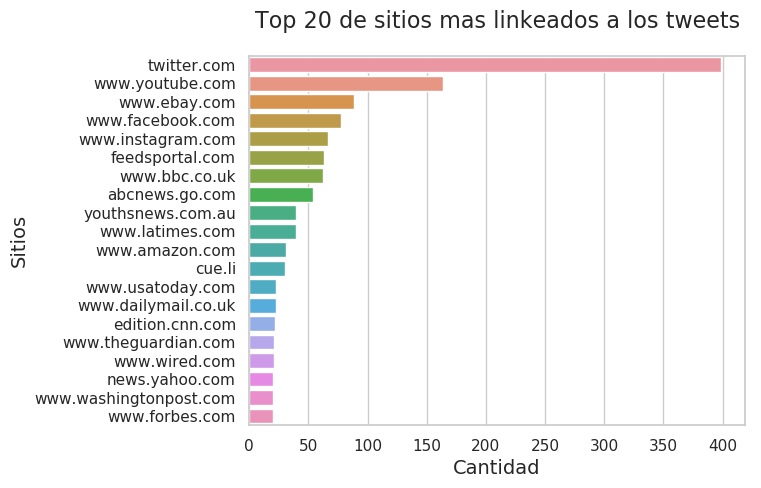

In [258]:
sites_top_20_filtered = twt_data_with_links.loc[filter_list].groupby('site').sum()\
    .sort_values('for_graphics', ascending=False).head(20).reset_index()
g = sns.barplot(x = 'for_graphics', y = 'site', data=sites_top_20_filtered)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

Text(0, 0.5, 'Sitios')

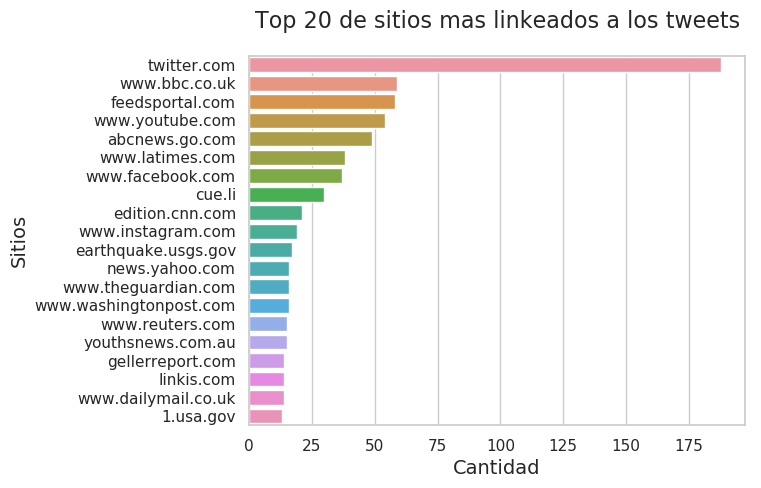

In [259]:
sites_top_20_filtered = twt_data_with_links.loc[filter_list].loc[twt_data_with_links['target']==1].groupby('site')\
    .sum().sort_values('for_graphics', ascending=False).head(20).reset_index()
g = sns.barplot(x = 'for_graphics', y = 'site', data=sites_top_20_filtered)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

Text(0, 0.5, 'Sitios')

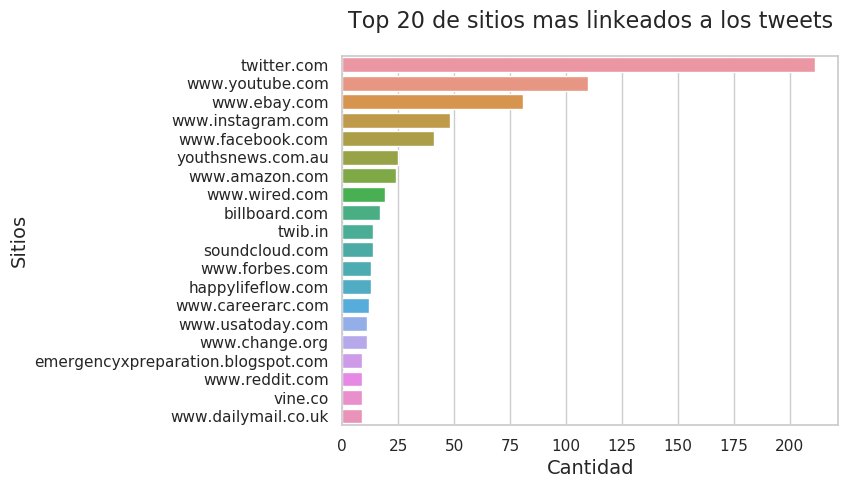

In [260]:
sites_top_20_filtered = twt_data_with_links.loc[filter_list].loc[twt_data_with_links['target']==0].groupby('site')\
    .sum().sort_values('for_graphics', ascending=False).head(20).reset_index()
g = sns.barplot(x = 'for_graphics', y = 'site', data=sites_top_20_filtered)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)